In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

from fastai.vision import *

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
    elif type(m) == nn.BatchNorm1d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def split_effnet(m):
    blocks_length = len(m._blocks)
    return ([m._conv_stem, m._bn0] + list(m._blocks.children())[:blocks_length//2], 
            list(m._blocks.children())[blocks_length//2:] + [m._conv_head, m._bn1],
            list(m.children())[5]
            )
def get_effnet(name="efficientnet-b0", pretrained=True, n_class=None):
    
    assert n_class != None, "Please specify the number of output classes `n_class`"
    
    if pretrained == True:
        print(f"Getting pretrained {name}")
        m = EfficientNet.from_pretrained(name)
    else:
        print(f"Getting random initialized {name}")
        m = EfficientNet.from_name(name)
    
    n_in = m._fc.in_features
    m._fc = nn.Sequential(
        nn.Dropout(p=0.5), 
        nn.Linear(n_in, n_class))
    m._fc.apply(init_weights)
    return m

def get_train_test_data(tfms=None, bs=32, sz=224, padding_mode='reflection', normalize=None):
    train_path, test_path = get_car_paths()
    train_df = get_cars_df('cars_train_annos.mat')
    test_df = get_cars_df('cars_test_annos_withlabels.mat')
    train_val_data = ImageDataBunch.from_df(train_path, train_df,
                                      ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs, padding_mode=padding_mode)
    test_data = ImageDataBunch.from_df(test_path, test_df,
                                      ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs, padding_mode=padding_mode)
    if normalize is not None:
        if normalize == "imagenet":
            train_val_data.normalize(imagenet_stats)
            test_data.normalize(imagenet_stats)
        elif normalize == "batch_stats":
            train_val_data.normalize()
            test_data.normalize(train_val_data.batch_stats)
        else:
            print("No normalization")
    return train_val_data, test_data

def get_learner(databunch, model, fp16=True):
    learn = Learner(databunch, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
    if fp16: learn.to_fp16()
    return learn

# Download and Untar Data

In [4]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')

# B3, size=300x300, 20 Epochs, normalize(imagenet_stats)

acc = 0.891278

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
tfms = get_transforms()
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300,300), normalize="imagenet")

In [10]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0036,  0.0113,  0.0279,  ...,  0.0231, -0.0258, -0.0206],
        [-0.0325, -0.0087,  0.0006,  ..., -0.0435,  0.0108, -0.0030],
        [ 0.0416, -0.0010, -0.0384,  ...,  0.0164,  0.0056,  0.0534],
        ...,
        [-0.0491,  0.0066,  0.0417,  ..., -0.0047, -0.0481,  0.0211],
        [-0.0211,  0.0488, -0.0081,  ...,  0.0428, -0.0212,  0.0288],
        [-0.0225,  0.0208, -0.0377,  ..., -0.0118, -0.0290, -0.0037]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.076705,4.647521,0.123464,01:35
1,2.693317,1.924430,0.489558,01:36
2,1.645522,2.356622,0.436732,01:37
3,1.650899,3.283628,0.289312,01:38
4,1.500285,2.418230,0.424447,01:36
5,1.343168,2.673287,0.369165,01:38
6,1.153504,2.338114,0.436732,01:39
7,1.025597,3.413372,0.290541,01:35
8,0.899928,2.236967,0.467445,01:37
9,0.769692,1.819411,0.539926,01:37


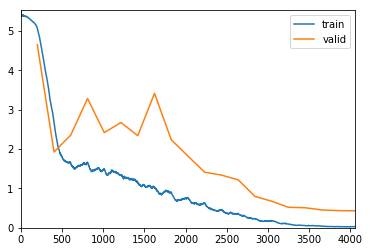

In [11]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [12]:
learn.save("b3_sz300x300_20epochs_normal-imagenet")

# B3, size=300x300, 20 Epochs, normalize(imagenet_stats), zoom_crop

acc = 0.901106

In [13]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [14]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300,300), normalize="imagenet")

In [15]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0178,  0.0437,  0.0047,  ..., -0.0637,  0.0454, -0.0054],
        [ 0.0510,  0.0463, -0.0109,  ..., -0.0373, -0.0324,  0.0469],
        [-0.0769,  0.0438, -0.0188,  ..., -0.0370, -0.0153, -0.0492],
        ...,
        [ 0.0292, -0.0003, -0.0333,  ...,  0.0025, -0.0236, -0.0471],
        [-0.0240, -0.0395,  0.0017,  ..., -0.0302, -0.0120,  0.0135],
        [-0.0413,  0.0344,  0.0430,  ..., -0.0167, -0.0475,  0.0610]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.106598,4.729920,0.100737,01:34
1,3.273760,2.394213,0.410934,01:34
2,2.169043,2.690168,0.356265,01:34
3,2.203341,2.849426,0.320639,01:34
4,2.212690,3.229796,0.277641,01:34
5,2.070830,2.715203,0.338452,01:34
6,1.844345,2.874846,0.313882,01:35
7,1.637539,2.358532,0.415848,01:34
8,1.381504,1.737738,0.549754,01:37
9,1.300062,1.946208,0.524570,01:35


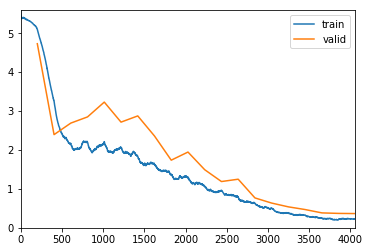

In [16]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [17]:
learn.save("b3_sz300x300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), zoom_crop

acc = 0.893120

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.162984,4.837645,0.092752,01:38
1,3.604719,2.849178,0.292998,01:36
2,2.599760,2.689834,0.338452,01:36
3,2.602536,3.171138,0.285012,01:37
4,2.445935,5.683571,0.203931,01:36
5,2.360094,3.398515,0.269656,01:36
6,2.098083,3.075146,0.277641,01:36
7,1.952321,2.017427,0.488329,01:36
8,1.693797,2.166955,0.441032,01:35
9,1.594281,1.539132,0.587224,01:37


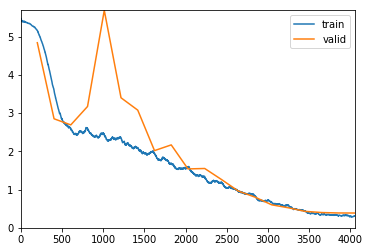

In [7]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [8]:
learn.save("b3_sz300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), zoom_crop(scale=(0.75, 1.5)), cutout, wd=1e-5

acc = 0.896192

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=1.)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.138037,4.810350,0.085995,01:39
1,3.428549,2.572322,0.369165,01:36
2,2.292538,2.466713,0.393120,01:37
3,2.148556,2.913030,0.370393,01:36
4,1.991544,2.971869,0.343980,01:36
5,1.879934,1.947132,0.504914,01:36
6,1.605572,2.170291,0.474201,01:36
7,1.352616,1.413570,0.655405,01:36
8,1.168514,1.653884,0.608722,01:36
9,1.035978,1.145420,0.689189,01:36


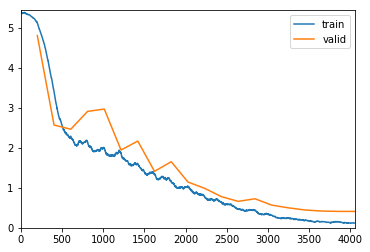

In [8]:
lr = 3e-3
wd = 1e-5
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [ ]:
learn.save("b3_sz300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 60 Epochs, normalize(imagenet_stats), zoom_crop, cutout, wd=1e-5

acc = 0.894349

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.230538,5.041955,0.063268,01:36
1,4.673914,4.156498,0.158477,01:34
2,3.538826,2.655498,0.394349,01:34
3,2.363300,1.641846,0.581695,01:34
4,1.668860,1.246353,0.657248,01:34
5,1.486862,1.369021,0.619165,01:34
6,1.452839,1.622259,0.608722,01:34
7,1.428270,1.586644,0.606880,01:34
8,1.507509,1.902603,0.564496,01:34
9,1.538894,1.748868,0.573710,01:34


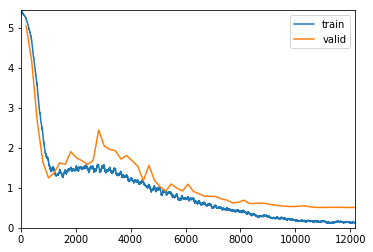

In [8]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [9]:
learn.save("b3_sz300_60epochs_001")

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop, cutout, wd=1e-5

acc = 0.897420

In [10]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [11]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [12]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0224, -0.0289, -0.0377,  ...,  0.0471,  0.0306,  0.0047],
        [-0.0432,  0.0205,  0.0051,  ..., -0.0160, -0.0561, -0.0043],
        [ 0.0130,  0.0037,  0.0018,  ...,  0.0440, -0.0344,  0.0071],
        ...,
        [ 0.0261, -0.0173,  0.0615,  ...,  0.0146, -0.0152, -0.0135],
        [ 0.0338,  0.0055, -0.0338,  ...,  0.0223,  0.0438,  0.0332],
        [ 0.0664,  0.0239, -0.0169,  ...,  0.0450, -0.0068, -0.0538]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.226843,5.032156,0.062654,01:33
1,4.504771,4.039878,0.171376,01:33
2,3.203168,2.522625,0.442875,01:33
3,2.017522,1.554249,0.605651,01:33
4,1.309885,1.210480,0.681204,01:33
5,1.164529,1.363132,0.642506,01:33
6,1.190534,1.632756,0.589066,01:33
7,1.200058,1.814980,0.565725,01:34
8,1.255345,1.987779,0.552211,01:33
9,1.273188,2.313967,0.494472,01:33


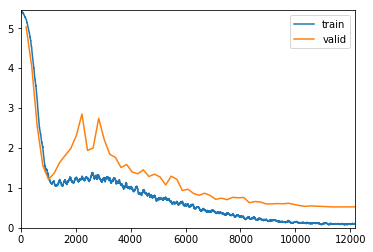

In [13]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [14]:
learn.save("b3_sz300_60epochs_002")

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop, cutout, wd=1e-5, LabelSmoothing

acc = 0.920147

In [15]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [16]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [17]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0350,  0.0016, -0.0346,  ..., -0.0598, -0.0003, -0.0370],
        [-0.0291, -0.0700, -0.0305,  ...,  0.0328,  0.0039,  0.0126],
        [ 0.0060, -0.0149,  0.0303,  ...,  0.0613,  0.0282, -0.0374],
        ...,
        [-0.0226, -0.0298,  0.0018,  ..., -0.0036, -0.0619,  0.0595],
        [-0.0309,  0.0332,  0.0542,  ..., -0.0068, -0.0067, -0.0230],
        [ 0.0095, -0.0236,  0.0039,  ...,  0.0379,  0.0808,  0.0179]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Land Rover LR2 SUV 2012,Geo Metro Convertible 1993,BMW 1 Series Coupe 2012,Toyota Sequoia SUV 2012,Lincoln Town Car Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1, 

epoch,train_loss,valid_loss,accuracy,time
0,5.216022,5.032703,0.063268,01:33
1,4.567908,4.070794,0.213145,01:33
2,3.439360,2.772541,0.523342,01:33
3,2.500875,2.059142,0.649263,01:33
4,2.063339,1.902398,0.694717,01:33
5,1.953768,1.926308,0.691646,01:33
6,1.922984,2.111172,0.631450,01:33
7,1.968901,2.280344,0.608108,01:34
8,2.003443,2.341126,0.591523,01:33
9,2.028057,2.383739,0.582310,01:33


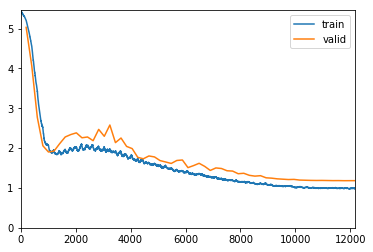

In [18]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [19]:
learn.save("b3_sz300_60epochs_003")

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop, cutout, wd=1e-5, LabelSmoothing, mixup

acc = 0.923219

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.261452,5.082067,0.052211,01:34
1,4.779532,4.280972,0.179361,01:38
2,3.994647,3.061420,0.399263,01:36
3,3.234458,2.261507,0.583538,01:34
4,2.799880,2.046139,0.641892,01:36
5,2.634579,2.096601,0.628378,01:34
6,2.617093,2.025749,0.657862,01:33
7,2.637721,2.234322,0.604423,01:34
8,2.669004,2.420606,0.573710,01:35
9,2.699150,2.375306,0.552211,01:35


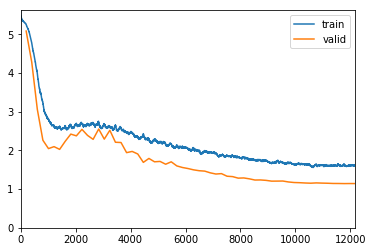

In [23]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [24]:
learn.save("b3_sz300_60epochs_004")

In [8]:
learn.load("b3_sz300_60epochs_004")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

In [9]:
learn.export("exported_models/exported.pkl")

# B3, size=(300x300), 20 Epochs, normalize(imagenet_stats), zoom_crop, wd=1e-5, LabelSmoothing, mixup

acc = 0.914005

In [10]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [11]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True)
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [12]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0382, -0.0037,  0.0276,  ..., -0.0339,  0.0026,  0.0116],
        [-0.0232, -0.0192, -0.0612,  ..., -0.0241, -0.0650,  0.0326],
        [ 0.0131,  0.0091, -0.0193,  ..., -0.0121,  0.0004, -0.0130],
        ...,
        [ 0.0639,  0.0190, -0.0217,  ..., -0.0451, -0.0064, -0.0432],
        [-0.0395, -0.0129, -0.0275,  ...,  0.0139, -0.0460, -0.0325],
        [-0.0229, -0.0088,  0.0008,  ...,  0.0323, -0.0127,  0.0362]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Dodge Journey SUV 2012,Dodge Charger Sedan 2012,Chevrolet Traverse SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Hyundai Genesis Sedan 2012,Acura Integra Type R 2001,Chevrolet Avalanche Crew Cab 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Chevrolet Silverado 1500 Extended Cab 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2d

epoch,train_loss,valid_loss,accuracy,time
0,5.200615,4.903356,0.072482,01:34
1,4.081461,3.185856,0.332310,01:34
2,3.450619,3.222067,0.345823,01:34
3,3.342707,3.400915,0.303440,01:34
4,3.251600,3.191902,0.406634,01:34
5,3.091748,3.228866,0.360565,01:34
6,2.992910,2.797984,0.491400,01:34
7,2.816722,2.367791,0.573096,01:34
8,2.637952,2.063539,0.673833,01:34
9,2.500136,1.965641,0.697789,01:36


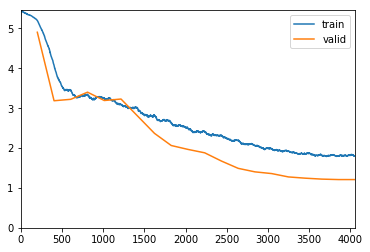

In [13]:
lr = 3e-3
wd = 1e-5
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [14]:
learn.save("b3_sz300_60epochs_005")

# B3, size=(300x300), 20 Epochs, normalize(imagenet_stats), zoom_crop, cutout, wd=1e-5, LabelSmoothing, mixup

acc = 0.904791

In [15]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [17]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True) + [cutout(n_holes=(1,2), length=(40, 60), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [18]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0387,  0.0400,  0.0271,  ..., -0.0138, -0.0536, -0.0622],
        [-0.0409, -0.0061, -0.0144,  ..., -0.0416, -0.0232,  0.0589],
        [ 0.0011, -0.0408, -0.0385,  ...,  0.0130,  0.0175, -0.0129],
        ...,
        [ 0.0522,  0.0302,  0.0393,  ..., -0.0065,  0.0585, -0.0228],
        [-0.0426, -0.0382,  0.0172,  ...,  0.0033,  0.0515, -0.0134],
        [-0.0477,  0.0115,  0.0008,  ..., -0.0113, -0.0274, -0.0571]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Ford Edge SUV 2012,Acura Integra Type R 2001,Hyundai Genesis Sedan 2012,McLaren MP4-12C Coupe 2012,BMW 1 Series Coupe 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(

epoch,train_loss,valid_loss,accuracy,time
0,5.211422,4.909228,0.070025,01:36
1,4.212939,3.313144,0.307125,01:34
2,3.477954,3.283005,0.329853,01:36
3,3.368873,3.489353,0.308968,01:36
4,3.377006,3.634404,0.352580,01:35
5,3.191431,2.992228,0.396806,01:34
6,3.042139,2.536987,0.517199,01:35
7,2.864335,2.448488,0.564496,01:37
8,2.777891,2.624644,0.595823,01:38
9,2.624716,1.951740,0.702088,01:40


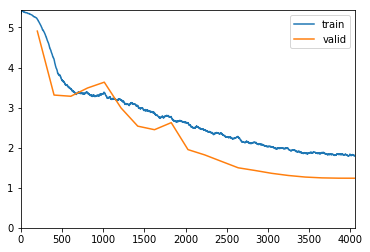

In [19]:
lr = 3e-3
wd = 1e-5
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [20]:
learn.save("b3_sz300_20epochs_006")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), rand_resize_crop

acc = 0.869779

In [6]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [7]:
tfms = get_transforms(xtra_tfms=rand_resize_crop(300, max_scale=2.0, ratios=(0.75, 1.33)))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [8]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0536, -0.0216,  0.0016,  ...,  0.0020,  0.0500,  0.0447],
        [-0.0192,  0.0428, -0.0357,  ...,  0.0522,  0.0246, -0.0467],
        [-0.0081,  0.0245, -0.0039,  ..., -0.0337, -0.0430, -0.0109],
        ...,
        [-0.0181,  0.0115,  0.0129,  ..., -0.0099,  0.0221, -0.0353],
        [-0.1010,  0.0380, -0.0561,  ...,  0.0691, -0.0047, -0.0425],
        [ 0.0142,  0.0740, -0.0543,  ...,  0.0185,  0.0211,  0.0200]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.078391,4.733749,0.097052,01:38
1,3.128467,2.471825,0.355651,01:37
2,2.065155,2.358328,0.408477,01:38
3,1.978597,3.256512,0.335995,01:38
4,1.908676,3.244434,0.273956,01:36
5,1.779976,2.793937,0.340295,01:37
6,1.498640,2.475498,0.382678,01:40
7,1.409567,2.404403,0.409091,01:39
8,1.220254,2.033123,0.486486,01:39
9,1.017412,1.934685,0.509828,01:39


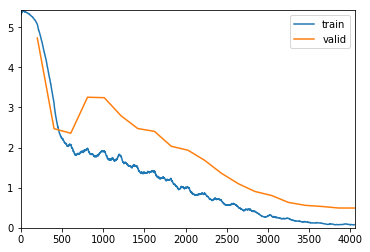

In [9]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [8]:
learn.save("b3_sz300_20epochs_normal-imagenet_rand_resize_crop")

# B3, sz=300, 20 Epochs, zoom_crop

acc = 0.900491

In [4]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [40]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, padding_mode="zeros")

In [42]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0072,  0.0721,  0.0491,  ..., -0.0071, -0.0148, -0.0271],
        [ 0.0085, -0.0438, -0.0097,  ..., -0.0791,  0.0018, -0.0702],
        [-0.0053, -0.0196, -0.0301,  ..., -0.0590,  0.0147, -0.1202],
        ...,
        [-0.0343,  0.0291,  0.0106,  ...,  0.0156,  0.0454,  0.0590],
        [-0.0174,  0.0005, -0.0278,  ...,  0.0194,  0.0529,  0.0159],
        [ 0.0051, -0.0319, -0.0159,  ..., -0.0302,  0.0350,  0.0167]],
       requires_grad=True)


In [44]:
learn = Learner(train_val_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Lamborghini Aventador Coupe 2012,Suzuki Aerio Sedan 2007,Suzuki Kizashi Sedan 2012,Dodge Caliber Wagon 2012,BMW 3 Series Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.165739,4.860180,0.076167,01:36
1,3.711944,2.759920,0.316339,01:34
2,2.729475,2.587435,0.358108,01:35
3,2.593584,3.182458,0.264742,01:35
4,2.458220,2.724496,0.351351,01:35
5,2.349305,2.797056,0.315725,01:35
6,2.177639,3.441000,0.233415,01:35
7,1.949889,2.396260,0.385135,01:35
8,1.753502,2.141473,0.454545,01:35
9,1.546982,1.884265,0.498157,01:37


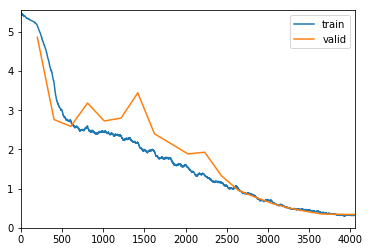

In [45]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [ ]:
learn.save("b3_sz300_20epochs_zoomcrop")

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop, wd=1e-5, LabelSmoothing, mixup

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,2.0), do_rand=True)
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.245312,5.047501,0.060811,01:34
1,4.783428,4.216805,0.175061,01:34
2,3.898960,2.922734,0.450246,01:34
3,3.130514,2.259289,0.600123,01:34
4,2.783135,2.181058,0.624079,01:34
5,2.629166,1.959982,0.665233,01:34
6,2.606921,2.161095,0.625307,01:34
7,2.589913,2.249611,0.600737,01:34
8,2.561589,2.191021,0.617322,01:34
9,2.689677,2.371197,0.565725,01:34


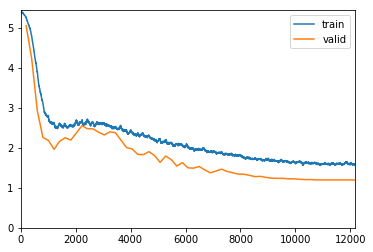

In [8]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [9]:
learn.save("b3_sz300_60epochs_010")

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop 1.2, cutout p0.5, wd=1e-5, LabelSmoothing, mixup

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.2), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.255710,5.044384,0.065111,01:34
1,4.651124,4.038998,0.225430,01:34
2,3.637526,2.740393,0.483415,01:33
3,2.849819,2.094747,0.657862,01:33
4,2.478132,1.893231,0.713145,01:34
5,2.332865,1.888494,0.702703,01:33
6,2.317989,2.151523,0.636978,01:33
7,2.342926,2.263163,0.609337,01:33
8,2.347319,2.330727,0.589066,01:33
9,2.327741,2.168817,0.646192,01:34


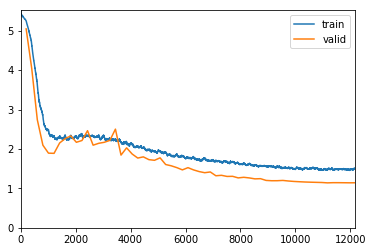

In [13]:
lr = 3e-3
wd = 1e-5
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [14]:
learn.save("b3_sz300_60epochs_011")

# B3, size=(300x300), 100 Epochs, normalize(imagenet_stats), zoom_crop 1.2, cutout p0.5, wd=1e-5, LabelSmoothing, mixup

In [15]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [16]:
xtra_tfms = zoom_crop(scale=(0.75,1.2), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [17]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0419, -0.0259,  0.0045,  ...,  0.0454,  0.0042,  0.0342],
        [-0.0261, -0.0003, -0.0019,  ...,  0.0437, -0.0226,  0.0193],
        [-0.0138,  0.0676,  0.0795,  ..., -0.0042, -0.0007, -0.0760],
        ...,
        [-0.0257, -0.0303, -0.0092,  ...,  0.0228, -0.0438, -0.0980],
        [ 0.0268, -0.0485,  0.0114,  ..., -0.0292,  0.0364,  0.0196],
        [ 0.0127, -0.0127, -0.0065,  ..., -0.0281,  0.0167,  0.0331]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
BMW M6 Convertible 2010,Suzuki SX4 Hatchback 2012,Ford E-Series Wagon Van 2012,Chevrolet Silverado 2500HD Regular Cab 2012,Volkswagen Golf Hatchback 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSa

epoch,train_loss,valid_loss,accuracy,time
0,5.245329,5.027651,0.060197,01:33
1,4.737675,4.197422,0.189803,01:33
2,3.900161,3.066196,0.423833,01:33
3,3.129447,2.268496,0.624079,01:33
4,2.581212,1.855884,0.734029,01:34
5,2.316579,1.730959,0.761056,01:34
6,2.170968,1.603254,0.796683,01:33
7,2.099219,1.735066,0.752457,01:34
8,2.071137,1.772412,0.746315,01:33
9,2.101140,1.717238,0.756757,01:33


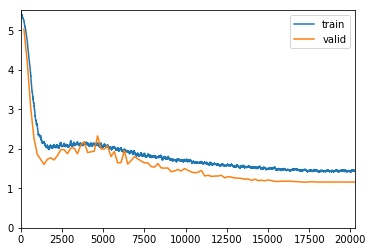

In [18]:
lr = 3e-3
wd = 1e-5
epochs = 100
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [19]:
learn.save("b3_sz300_100epochs_001")

# B0, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop 1.5, cutout p0.8, wd=1e-3, LabelSmoothing, mixup

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b0", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Parameter containing:
tensor([[ 0.0578,  0.0263, -0.0778,  ..., -0.0094, -0.0485, -0.0246],
        [-0.0734, -0.0396, -0.0109,  ...,  0.0324,  0.0119, -0.0037],
        [ 0.0089, -0.0328,  0.0024,  ..., -0.0174,  0.0379, -0.0387],
        ...,
        [-0.0383,  0.0002, -0.0413,  ..., -0.0609, -0.0292,  0.0201],
        [ 0.0377, -0.0567, -0.0270,  ..., -0.0283, -0.0108,  0.0571],
        [-0.0219, -0.0084, -0.0193,  ..., -0.0436, -0.0485, -0.0315]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.255009,5.042468,0.063268,00:59
1,4.828648,4.323233,0.156634,00:59
2,4.046984,3.217035,0.380835,00:59
3,3.290459,2.419346,0.550983,00:59
4,2.820600,2.037461,0.657248,00:59
5,2.586259,1.978913,0.676290,01:00
6,2.457248,2.007910,0.673833,01:00
7,2.463569,2.042022,0.669533,00:59
8,2.446822,2.094139,0.656634,01:00
9,2.501967,2.276641,0.621007,01:00


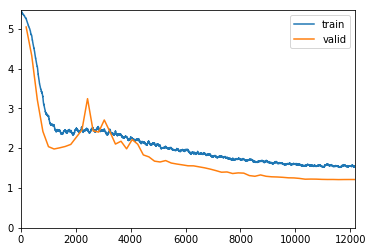

In [28]:
lr = 3e-3
wd = 1e-3
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [29]:
learn.save("b0_sz300_60epochs_001")

In [8]:
learn.load("b0_sz300_60epochs_001")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

In [11]:
learn.export("exported_models/b0_300x300_2.pkl")

# B0, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop 1.2, cutout p0.5, wd=1e-3, LabelSmoothing, mixup

acc = 0.936118

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.2), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b0", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Parameter containing:
tensor([[ 0.0578,  0.0263, -0.0778,  ..., -0.0094, -0.0485, -0.0246],
        [-0.0734, -0.0396, -0.0109,  ...,  0.0324,  0.0119, -0.0037],
        [ 0.0089, -0.0328,  0.0024,  ..., -0.0174,  0.0379, -0.0387],
        ...,
        [-0.0383,  0.0002, -0.0413,  ..., -0.0609, -0.0292,  0.0201],
        [ 0.0377, -0.0567, -0.0270,  ..., -0.0283, -0.0108,  0.0571],
        [-0.0219, -0.0084, -0.0193,  ..., -0.0436, -0.0485, -0.0315]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.254633,5.096426,0.038698,00:58
1,4.856395,4.322017,0.159091,00:59
2,4.001905,3.115630,0.396192,00:59
3,3.140227,2.265328,0.621622,00:59
4,2.677396,2.010758,0.677518,00:58
5,2.511854,2.001122,0.696560,00:59
6,2.384186,2.062442,0.662776,00:58
7,2.391763,2.100782,0.649263,00:59
8,2.374131,2.086936,0.656634,00:58
9,2.427301,2.318772,0.617936,00:58


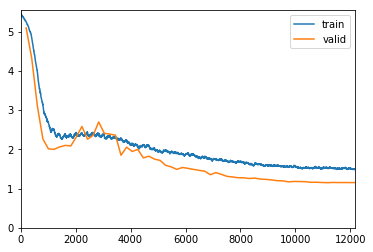

In [33]:
lr = 3e-3
wd = 1e-3
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [34]:
learn.save("b0_sz300_60epochs_011")

In [8]:
learn.load("b0_sz300_60epochs_011")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

In [9]:
learn.export("exported_models/b0_300x300_best.pkl")

# B0, size=(300x300), 40 Epochs, normalize(imagenet_stats), zoom_crop 1.2, cutout p0.5, wd=1e-3, LabelSmoothing, mixup

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.2), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b0", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Parameter containing:
tensor([[ 0.0578,  0.0263, -0.0778,  ..., -0.0094, -0.0485, -0.0246],
        [-0.0734, -0.0396, -0.0109,  ...,  0.0324,  0.0119, -0.0037],
        [ 0.0089, -0.0328,  0.0024,  ..., -0.0174,  0.0379, -0.0387],
        ...,
        [-0.0383,  0.0002, -0.0413,  ..., -0.0609, -0.0292,  0.0201],
        [ 0.0377, -0.0567, -0.0270,  ..., -0.0283, -0.0108,  0.0571],
        [-0.0219, -0.0084, -0.0193,  ..., -0.0436, -0.0485, -0.0315]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.242587,5.066722,0.052211,01:00
1,4.699122,4.095806,0.208845,00:59
2,3.624947,2.727587,0.456388,00:58
3,2.932530,2.352403,0.551597,00:58
4,2.637507,3.014800,0.401106,00:59
5,2.597049,2.672515,0.488943,00:58
6,2.584540,2.534216,0.527641,00:58
7,2.615734,2.616491,0.490172,00:58
8,2.600395,2.678092,0.518427,00:58
9,2.581567,2.469617,0.577396,00:59


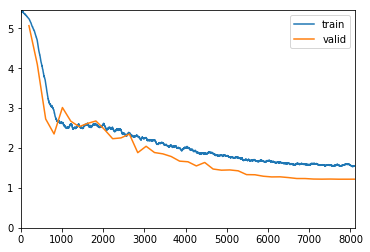

In [15]:
lr = 3e-3
wd = 1e-3
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [16]:
learn.save("b0_sz300_40epochs_021")

In [8]:
learn.load("b0_sz300_40epochs_021")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size

# B3, size=(300x300), 60 Epochs, normalize(imagenet_stats), zoom_crop 1.5, cutout p0.8, wd=1e-5, LabelSmoothing, mixup

In [35]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [36]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.8)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300, 300), normalize="imagenet")

In [37]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn.to_fp16()

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0495, -0.0465,  0.0130,  ..., -0.0298, -0.0040,  0.0588],
        [-0.0211,  0.0086,  0.0120,  ...,  0.0186,  0.0028,  0.0378],
        [-0.0416,  0.0104, -0.0075,  ...,  0.0444, -0.0338, -0.0107],
        ...,
        [-0.0088, -0.0501, -0.0270,  ...,  0.0581,  0.0089,  0.0060],
        [ 0.1170, -0.0492,  0.0538,  ..., -0.0273,  0.0469,  0.0261],
        [-0.0158,  0.0151,  0.0020,  ..., -0.0684,  0.0088, -0.0035]],
       requires_grad=True)


Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Aston Martin Virage Coupe 2012,Honda Accord Coupe 2012,Land Rover Range Rover SUV 2012,Ford Freestar Minivan 2007,Bugatti Veyron 16.4 Coupe 2009
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40

epoch,train_loss,valid_loss,accuracy,time
0,5.231212,5.028637,0.078010,01:33
1,4.682130,4.054018,0.220516,01:34
2,3.646350,2.714485,0.519656,01:34
3,2.899469,2.046319,0.643735,01:34
4,2.527941,1.948936,0.679975,01:34
5,2.410370,1.974418,0.668305,01:34
6,2.399850,2.030266,0.664619,01:34
7,2.398074,2.054531,0.680590,01:33
8,2.423125,2.585084,0.515356,01:34
9,2.412072,2.244997,0.613022,01:33


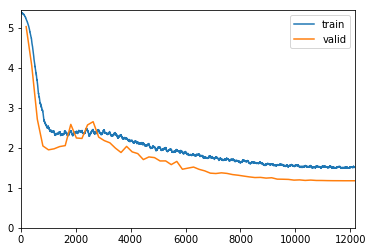

In [38]:
lr = 3e-3
wd = 1e-3
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [39]:
learn.save("b3_sz300_60epochs_021")

# fin